In [2]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from Kildekode._11_Frekvensrespons import *

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

def displayFrequencyResponse(b, a=[1], num=None, mag='log', new_figure=True, **kwargs):
    w, Hw = sig.freqz(b, a)
    H_amp = np.abs(Hw)
    H_phase = np.unwrap(np.angle(Hw, deg=True), period=360)
    if new_figure==True:
        if num is not None:
            plt.close(num)
        fig, [ax1, ax2] = plt.subplots(num=num, nrows=2)
    else :
        fig = plt.figure(num=num)
        ax1 = fig.axes[0]
        ax2 = fig.axes[1]
    
    if mag.lower()=='log':
        ax1.plot(w, 20*np.log10(H_amp), **kwargs)
        ax1.set_ylabel(r'$\left| H\left(\hat{\omega}\right)\right|$ (dB)')
    else:
        ax1.plot(w, H_amp, **kwargs)
        ax1.set_ylabel(r'$\left| H\left(\hat{\omega}\right)\right|$')

    ax1.set_xticks(np.linspace(0, 1, 6)*pi, [str(round(i,2))+r'$\pi$' for i in np.linspace(0, 1, 6)])
    ax1.set_xlabel(r'Digital Frekvens $\hat{\omega}$')

    ax1.set_xlim([0, pi])
    ax1.set_title(r'Frekvensrespons $H\left(\hat{\omega}\right)$')

    phaseResp, = ax2.plot(w, H_phase, **kwargs)

    ax2.set_xticks(np.linspace(0, 1, 6)*pi, [str(round(i,2))+r'$\pi$' for i in np.linspace(0, 1, 6)])
    ax2.set_xlabel(r'Digital Frekvens $\hat{\omega}$')
    ax2.set_ylabel(r'$\angle H\left(\hat{\omega}\right)$ (degrees)')

    if "label" in kwargs.keys():
        ax2.legend()
        ax1.legend()
    fig.tight_layout(pad=0.1, w_pad=1.0, h_pad=1.0)

%matplotlib ipympl

<img src="figures/NTNU_logo_vertical.svg" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Designing Highpass, Bandpass and Bandstop FIR filters

* **Emne AIS2201 - Signalbehandling**
* **Uke 43, 2025**
* **Relevant Pensum:**
    * Kapittel 5.3 - 5.6 i læreboka Understanding Digital Signal Processing
* **Underviser: Kai Erik Hoff**

# Topics:

* Modulating FIR filters
* FIR filters in Parallell
* Cascaded FIR filters
* Complementary filters

# It all starts with lowpass filters

* FIR filters are very easy to modify, as we can manipulate the impulse response $h[n]$ directly

* Given some lowpass filter with a passband $\hat{\omega} \in (-\hat{\omega}_{\text{pass}}, \hat{\omega}_{\text{pass}})$, other types of filters can be created by simply *moving the passband to a different "location"*

* **Amplitude Modulation:**

|Operation |Time-domain $h[n]$|Frequency domain $H\left(\hat{\omega}\right)$|
|:--|:----------:|:-----------------------:|
|Modulasjon | $$h[n]\cdot \cos (\hat{\omega}_0 \cdot n)$$ | $$\frac{1}{2}H\left(\hat{\omega}-\hat{\omega}_0\right) + \frac{1}{2}H\left(\hat{\omega}+\hat{\omega}_0\right)$$| 

# Lowpass filter $\rightarrow$ Highpass filter

* A lowpass filter can be converted to a highpass filter by mixing the impulse respionse with a sinusoid at the nyquist frequenc $\frac{f_s}{2} \text{ Hz}$ / $\pi \text{ rad}$.
    \begin{align}
    h_{HP}[n] &= h_{LP}[n]\cdot \cos\left(\pi\cdot \left(n - \tiny{\frac{M-1}{2}} \right) \right)\\
    &= h_{LP}[n]\cdot \left(e^{j\pi\cdot n}+e^{-j\pi\cdot n}\right) \cdot \frac{1}{2}\\
    &=  h_{LP}[n]\cdot e^{j\pi\cdot n} +  h_{LP}[n]\cdot e^{-j\pi\cdot n}\cdot \frac{1}{2} \\ \\
    H_{HP}(\hat{\omega})&= \left(H_{LP}(\hat{\omega} - \pi) + H_{LP}(\hat{\omega} + \pi)\right) \cdot \frac{1}{2} \\
  &= \left(2\cdot H_{LP}(\hat{\omega} - \pi)\right) \cdot \frac{1}{2} \ \ \ \text{(aliasing)}\\
  &= H_{LP}(\hat{\omega} - \pi)
    \end{align}

# Highpass filter example:
* Create a $M=129$-tap highpass filter with $-6\text{dB}$ corner frequency $\hat{\omega}_{\text{c}} = 0.8\pi$ by modulating a lowpass filter.


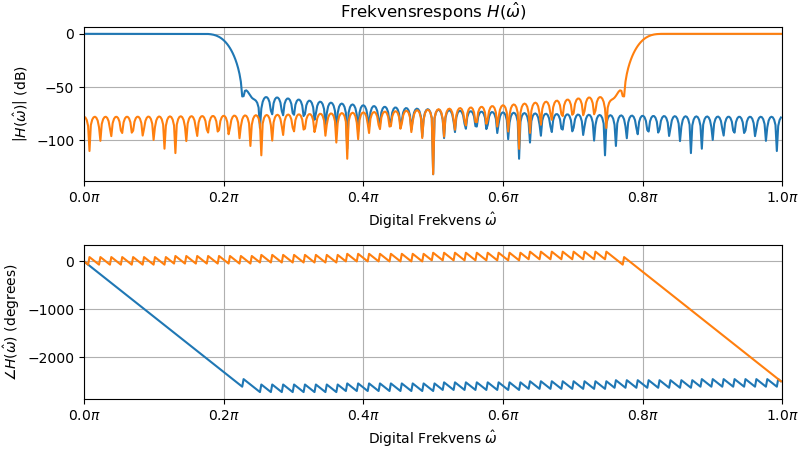

In [28]:
M = 129

w_c = 0.2*pi 

n = np.arange(M)
hn_lp = w_c/pi*np.sinc(w_c/pi*(n-(M-1)/2)) # Lavpassfilter uten vindusfunksjon
hn_lp *= sig.windows.hamming(M) # Legg til vindusfunksjon "hamming"

hn_hp = hn_lp*cos(pi*(n-(M-1)/2)) # Frekvensforskyvning av passbånd

displayFrequencyResponse(b=hn_lp, num=4)
displayFrequencyResponse(b=hn_hp, num=4, new_figure=False)

# Lowpass filter $\rightarrow$ Bandpass filter

* A lowpass filter can be converted to a bandpass filter by mixing the impulse response $h[n]$ by an appropriate sinusoid.
    \begin{align}
    h_{BP}[n] &= 2\cdot h_{LP}[n]\cdot \cos(\hat{\omega}_{BP}\cdot n)\\
    &= h_{LP}[n]\cdot \left(e^{j\hat{\omega}_{BP}\cdot n}+e^{-j\hat{\omega}_{BP}\cdot n}\right)\\
    &=  h_{LP}[n]\cdot e^{j\hat{\omega}_{BP}\cdot n} +  h_{LP}[n]\cdot+e^{-j\hat{\omega}_{BP}\cdot n} \\ \\
    H_{BP}(\hat{\omega})&= H_{LP}(\hat{\omega} - \hat{\omega}_{BP}) + H_{LP}(\hat{\omega} + \hat{\omega}_{BP})
    \end{align}
    * $\hat{\omega}_{BP}$ is now the centre of the passband, with the bandpass filter's passband having *twice the width* of the lowpass filter's passband.
    * Since the negatively and positively shifted passbands do not overlap (as they do with highpass filters due to aliasing), we must compensate for halved magnitude by scaling with $2$.

# Bandpass filter example:
* Create a $M=129$-tap bandpass filter with  $\hat{\omega}_{\text{lower}} = 0.3\pi$ og $\hat{\omega}_{\text{upper}} = 0.5\pi$ by modulating a lowpass filter.

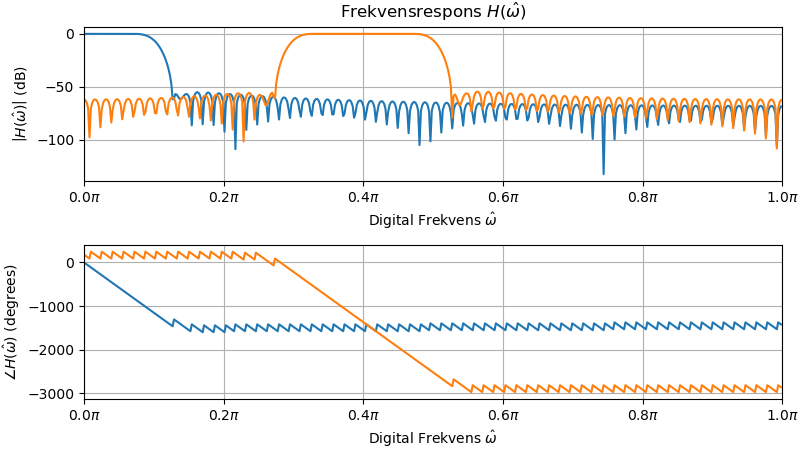

In [31]:
M = 129

w_c = 0.1*pi 

n = np.arange(M)
hn_lp = w_c/pi*np.sinc(w_c/pi*(n-(M-1)/2)) # Lavpassfilter uten vindusfunksjon
hn_lp *= sig.windows.hamming(M) # Legg til vindusfunksjon "hamming"

hn_bp = hn_lp*2*cos(0.4*pi*(n-(M-1)/2)) # Frekvensforskyvning av passbånd

displayFrequencyResponse(b=hn_lp, num=4)
displayFrequencyResponse(b=hn_bp, num=4, new_figure=False)

# FIR filters in Parallell

<div>
<img src="figures/parallell.svg" style="width: 50%; margin-left:100px"/>
</div>
<br>

* Full system frequency response is sum of component frequency responses:

$$\large H(\hat{\omega}) = H_A(\hat{\omega}) + H_A(\hat{\omega})$$

# Bandstop Filter:
* Create a $M=129$-tap bandstop filter with stopband between $\hat{\omega}_{\text{low}} = 0.3\pi$ and $\hat{\omega}_{\text{high}} = 0.5\pi$

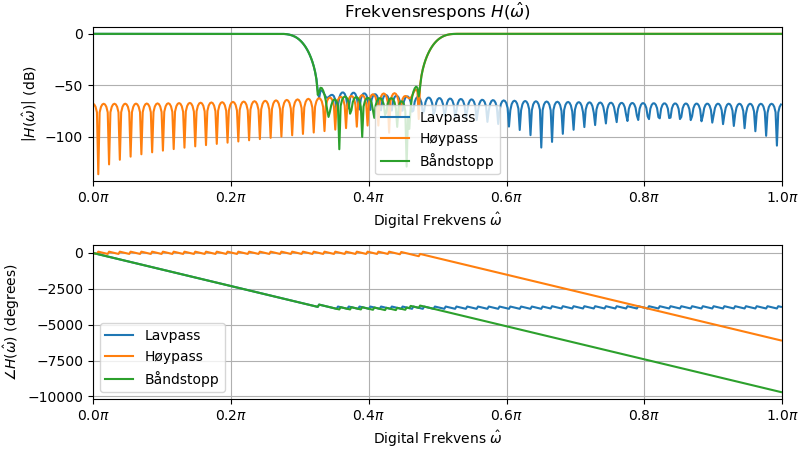

In [72]:
M = 128


n = np.arange(M+1)
hn_lp = 0.3*np.sinc(0.3*(n-M/2)) # Lavpassfilter uten vindusfunksjon
hn_lp *= sig.windows.hamming(M+1) # Legg til vindusfunksjon "hamming"


hn_hp = 0.5*np.sinc(0.5*(n-M/2)) # Lavpassfilter uten vindusfunksjon
hn_hp *= sig.windows.hamming(M+1) # Legg til vindusfunksjon "hamming"
hn_hp *= cos(pi*(n-M/2))

hn_bs = hn_lp + hn_hp

displayFrequencyResponse(b=hn_lp, label="Lavpass", num=4)
displayFrequencyResponse(b=hn_hp, label="Høypass",num=4, new_figure=False)
displayFrequencyResponse(b=hn_bs, label="Båndstopp", num=4, new_figure=False)

# FIR filters in Cascade

<div>
<img src="figures/cascade.svg" style="width: 50%; margin-left:100px"/>
</div>
<br>

* Full system frequency response is product of component frequency responses:

$$\large H(\hat{\omega}) = H_A(\hat{\omega}) \cdot H_A(\hat{\omega})$$

# Bandpass filter example:
* Create a $M=129$-tap bandpass filter with  $\hat{\omega}_{\text{lower}} = 0.3\pi$ og $\hat{\omega}_{\text{upper}} = 0.5\pi$ by cascading two FIR filters of equal length

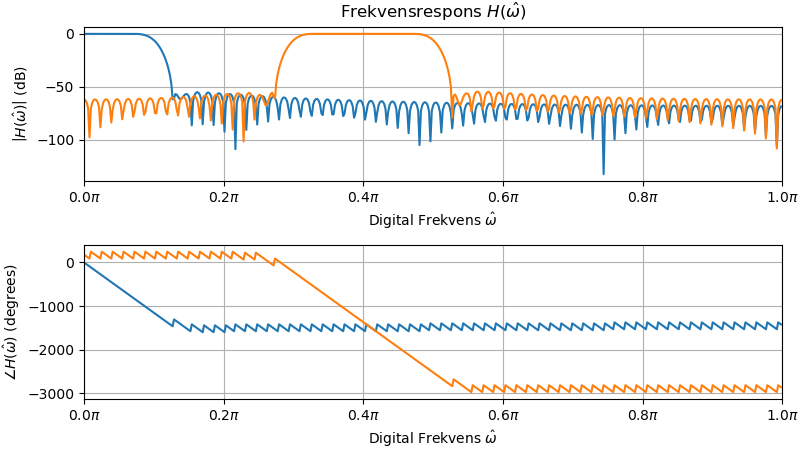

In [31]:
M = 129

w_c = 0.1*pi 

n = np.arange(M)
hn_lp = w_c/pi*np.sinc(w_c/pi*(n-(M-1)/2)) # Lavpassfilter uten vindusfunksjon
hn_lp *= sig.windows.hamming(M) # Legg til vindusfunksjon "hamming"

hn_bp = hn_lp*2*cos(0.4*pi*(n-(M-1)/2)) # Frekvensforskyvning av passbånd

displayFrequencyResponse(b=hn_lp, num=4)
displayFrequencyResponse(b=hn_bp, num=4, new_figure=False)

# Complementary Filters

* A filter with magnitude response $|H(\hat{\omega})|$ will have a complementary filter $H_{\text{comp}}(\hat{\omega})$ with magnitude response defined as:
$$|H_{\text{comp}}(\hat{\omega})| = 1 - |H(\hat{\omega})|$$
* For FIR filters with ***uniform group delay*** $D(\hat{\omega}) = K$ (i.e. linear phase response), the complementary filter is found by:
    * Creating a "allpass" system with group delay $D(\hat{\omega}) = K$
    * Subtracting the initial filter's impulse response from the allpass filter's impulse response.

* For FIR filters $h[n]$ with *odd* number of taps $M$
$$h_{\text{comp}}[n] = \delta\left[n-\frac{M-1}{2}\right] - h[n]$$

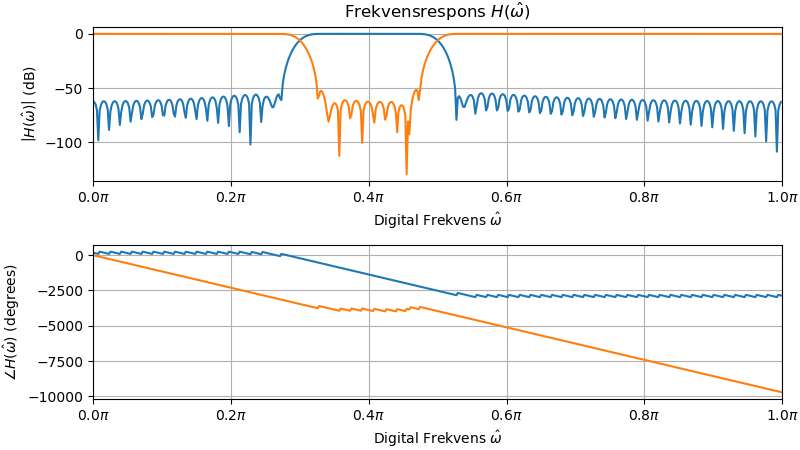

In [75]:
#displayFrequencyResponse(hn_bs, num=5)
M = len(hn_bs)

# Delayed delta pulse
dn = np.zeros(M)
dn[int((M-1)/2)] = 1

hn = dn - hn_bs

displayFrequencyResponse(hn, num=5, new_figure=True)
displayFrequencyResponse(hn_bs, num=5, new_figure=False)
#plt.figure()
#plt.stem(hn)
#plt.stem(hn_lp)

#### Quiz-question:
* Why not even-numbered taps?

# Band-splitting

* Complementary filters are very useful for "splitting" a signal into two frequency bands, where summing the two bands will reproduce the original signal with no distortion

* Instead of calculating the complementary filter, we can subtract filtered signal from source signal.

<div>
<img src="figures/band_splitter.svg" style="width: 60%; margin-left:100px"/>
</div>


# Summary

* Design av FIR filtre går ut på å definere ønskede egenskaper i frekvensdomenet, og regne seg fram til en impulsrespons som kommer så nære de egenskapene som mulig.
    * Gir veldig stor fleksibilitet til å finne *nøyaktig* det filteret vi ønsker, men kan ofte involvere *svært* høy filterorden.
* Den *lineære faseresponsen* er ofte hovedmotivasjonen for å bruke FIR filtre.
    * Dersom de forskjellige frekvenskomponentene i et signal forskyves ulikt, vil også signalets *bølgeform* påvirkes. Dette er f.eks. ikke gunstig for lydsignal, og FIR filtre dominerer i behandling av lydsignal av den grunn.

# Andre spørsmål?